In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Convolutional Neural Networks for modelling FASHION MNIST dataset

* @Author: Sameer Kesava

        
         * Input Layer: (28,28,1)
         * Batch size: 32
         * 1st Convolutional Layer: kernel size - (3,3,64)
         * Max Pooling: non-overlapping kernel - (2,2)
         * 2nd Convolutional Layer: kernel size - (3,3,128)
         * Max Pooling: non-overlapping - (2,2)
         * 1st Fully Dense Layer: 2048 units
         * Dropout at the 1st Fully Dense Layer: p = 0.5
         * 2nd Fully Dense Layer: 10 output units
         * Epochs = 40
         * Test data accuracy: 92.41%

## Loading the data set

In [2]:
from tensorflow.keras.datasets import fashion_mnist

In [3]:
dataset = fashion_mnist.load_data()

## Exploratory Data Analysis

In [4]:
x_train = dataset[0][0]
y_train = dataset[0][1]

print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [5]:
x_test = dataset[1][0]
y_test = dataset[1][1]

print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


In [6]:
import numpy as np

In [7]:
y_unique = np.unique(y_train)
y_unique

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
import matplotlib.pyplot as plt

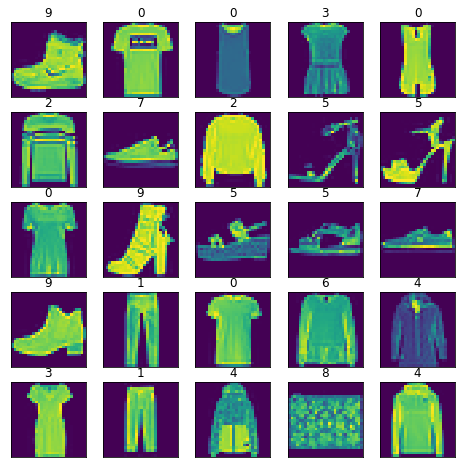

In [9]:
fig1, ax1 = plt.subplots(nrows = 5, ncols=5, figsize = (8,8))
ax1 = ax1.flatten()

for i, ax in enumerate(ax1):
    ax.imshow(x_train[i])
    ax.set_title(y_train[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [10]:
del dataset

## Data Preprocessing

#### Creating training, validation and test data sets

In [11]:
X_train = x_train.reshape(-1, x_train.shape[1]*x_train.shape[2])
X_train.shape

(60000, 784)

In [12]:
X_test = x_test.reshape(-1, x_test.shape[1]*x_test.shape[2])
X_test.shape

(10000, 784)

#### Creating a shuffle object for shuffling the data 

In [13]:
#Creating a randomstate object for shuffling
shuffler = np.random.RandomState(seed = 10)
shuffled_idx = list(range(len(y_train)))
shuffler.shuffle(shuffled_idx)
len(shuffled_idx)

60000

In [14]:
shuffled_idx[:10]

[4883, 28477, 8527, 38347, 3363, 36370, 6083, 34418, 18938, 17773]

In [15]:
y_train[0:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [16]:
y_train[shuffled_idx[:10]]

array([9, 2, 1, 4, 3, 9, 0, 3, 7, 7], dtype=uint8)

In [17]:
# Splitting into training and validation features
X_valid = X_train[shuffled_idx[:10000]]
X_train = X_train[shuffled_idx[10000:]]

In [18]:
# Splitting into training and validation labels
y_valid = y_train[shuffled_idx[:10000]]
y_train = y_train[shuffled_idx[10000:]]

In [19]:
y_train.shape

(50000,)

In [20]:
X_valid.shape

(10000, 784)

In [21]:
X_train.shape

(50000, 784)

In [22]:
X_train.dtype

dtype('uint8')

#### Scaling the data

In [23]:
# Mean along each column which is this case number 784
mean_px = np.mean(X_train, axis=0)
mean_px.shape

(784,)

In [24]:
# Standard deviation is calculated across the whole dataset because std across white spaces will be 0 leading to scaling to infinity
std_px = np.std(X_train)
std_px

90.0032988362806

In [25]:
type(std_px)

numpy.float64

In [26]:
X_train_scaled = (X_train - mean_px)/std_px
X_train_scaled.shape

(50000, 784)

In [27]:
X_train_scaled.dtype

dtype('float64')

In [28]:
print('Min and Max of training set: ', np.max(X_train_scaled), np.min(X_train_scaled))

Min and Max of training set:  2.8323181849557026 -1.798997615571078


In [29]:
X_valid_scaled = (X_valid - mean_px)/std_px
X_valid_scaled.shape

(10000, 784)

In [30]:
print('Min and Max of validation set: ', np.max(X_valid_scaled), np.min(X_valid_scaled))

Min and Max of validation set:  2.8292927402939982 -1.798997615571078


In [31]:
X_test_scaled = (X_test - mean_px)/std_px
X_test_scaled.shape

(10000, 784)

In [32]:
print('Min and Max of test set: ', np.max(X_test_scaled), np.min(X_test_scaled))

Min and Max of test set:  2.8274012540684805 -1.798997615571078


In [33]:
# The input tensor has to be 4D
X_train_scaled = X_train_scaled.reshape(-1, 28,28,1)
X_train_scaled.shape

(50000, 28, 28, 1)

In [34]:
X_valid_scaled = X_valid_scaled.reshape(-1, 28,28,1)
X_valid_scaled.shape

(10000, 28, 28, 1)

In [35]:
X_test_scaled = X_test_scaled.reshape(-1, 28,28,1)
X_test_scaled.shape

(10000, 28, 28, 1)

## Building CNN

In [36]:
import tensorflow as tf

In [37]:
#if using python2.7
from __future__ import division

In [38]:
def cnn_layer(input_tensor, kernel_size, nfeaturemaps, padding_mode = 'SAME', stride = (1,1,1,1), name='layer'):
    
    """ Function for a convolutional layer"""
    
    # stride: dimension must be the same as the input_tensor
    
    with tf.variable_scope(name): # scope for each cov layer
        
        shape = input_tensor.get_shape().as_list() 
        # batchsize x nrows x ncolumns x nchannels
        
        n_input_channels = shape[-1] # no. of input channels in the images
        
        kweights_shape = list(kernel_size) + [n_input_channels, nfeaturemaps]
        # setting dimensions of the kernel tensor: nrows x ncols x ninputchannels x nfeaturemaps
        
        weights = tf.get_variable(name='_weights', shape = kweights_shape)
        # default initializer is the Glorot initializer which requires float64
        print(weights)
        
        biases = tf.get_variable(name = '_biases', initializer=tf.zeros(shape = [nfeaturemaps]))
        # initializing biases which are added at the end after the convolution of the weight matrix with the input tensor
        print(biases)
        
        conv_layer = tf.nn.conv2d(input = input_tensor, filter = weights, strides = stride, padding = padding_mode,
                           data_format='NHWC')
        # takes 4D input
        print(conv_layer)
        
        conv_layer = tf.nn.bias_add(conv_layer, biases, name = 'preactivation')
        # adding bias b to W*X
        print(conv_layer)
        
        conv_layer = tf.nn.relu(conv_layer, name = 'activation')
        print(conv_layer)
        
        return conv_layer  
    

# Testing    
g = tf.Graph()
with g.as_default():
    
    x = tf.placeholder(dtype = tf.float32, shape = (None, 28,28,2), name = 'x')
    # the dtype of input feed, weights and biases need to be the same.
    
    conv_layer = cnn_layer(x, (3,3), 10, 'SAME', (1,1,1,1), 'layer1')

del g, x 

<tf.Variable 'layer1/_weights:0' shape=(3, 3, 2, 10) dtype=float32_ref>
<tf.Variable 'layer1/_biases:0' shape=(10,) dtype=float32_ref>
Tensor("layer1/Conv2D:0", shape=(?, 28, 28, 10), dtype=float32)
Tensor("layer1/preactivation:0", shape=(?, 28, 28, 10), dtype=float32)
Tensor("layer1/activation:0", shape=(?, 28, 28, 10), dtype=float32)


In [39]:
def pooling_layer(conv_tensor, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME'):
    
    """Pooling the convolutional layer"""
       
    # strides.shape = ksize.shape for non-overlapping pooling
    
    return tf.nn.max_pool(conv_tensor, ksize, strides, padding = 'SAME')       

In [40]:
def fully_connected_layer(input_tensor, n_output_units, name, activation_fn = None):

    """Defining the fully connected layer"""
      
    with tf.variable_scope(name):
            
        input_shape = input_tensor.get_shape().as_list()
       
        unit_shape = input_shape[1:]
        # Shape of the input tensor to the fully connected layer. 
        # should be: batch_size x no. of units
        # Need to check if the input tensor is flattened
                     
        n_input_units = np.prod(unit_shape)
        
        if(len(unit_shape) > 1):
            input_tensor = tf.reshape(input_tensor, shape = (-1, n_input_units))
        
        weights = tf.get_variable(name = '_weights', shape = [n_input_units, n_output_units])
        print(weights)
        
        biases = tf.get_variable(name = '_biases', initializer = tf.zeros(shape = [n_output_units]))
        print(biases)
        
        perceptron = tf.matmul(input_tensor, weights)
        print(perceptron)
        
        perceptron = tf.nn.bias_add(perceptron, biases, name='preactivation')
        print(perceptron)
        
        if activation_fn is None:
            return perceptron
        
        perceptron = activation_fn(perceptron, name = 'activation')
        print(perceptron)
        
                
        return perceptron

# Testing
g = tf.Graph()

with g.as_default():
    
    x = tf.placeholder(dtype = tf.float32, shape = (None, 28,28,2), name = 'x')
    
    fc_layer = fully_connected_layer(x, 10, 'layer_1', activation_fn=tf.nn.relu)

del g, x 

<tf.Variable 'layer_1/_weights:0' shape=(1568, 10) dtype=float32_ref>
<tf.Variable 'layer_1/_biases:0' shape=(10,) dtype=float32_ref>
Tensor("layer_1/MatMul:0", shape=(?, 10), dtype=float32)
Tensor("layer_1/preactivation:0", shape=(?, 10), dtype=float32)
Tensor("layer_1/activation:0", shape=(?, 10), dtype=float32)


In [41]:
def cnn_build(learning_rate = 1e-4):
    """Building CNN"""
    
    # Placeholders for x and y
    ts_x = tf.placeholder(tf.float32, shape =(None, 28, 28, 1), name = 'ts_x')
    ts_y = tf.placeholder(tf.int32, shape = (None), name = 'ts_y')
    
    # encoding y values
    y_onehot = tf.one_hot(indices= ts_y, depth = len(y_unique), dtype = tf.float32, name = 'y_onehot')
    
    
    # 1st Convolution layer
    print('\nBuilding 1st convolution layer: ')
    conv1 = cnn_layer(input_tensor=ts_x, kernel_size=(3,3), nfeaturemaps=64, padding_mode='SAME', stride=(1,1,1,1),
                     name='conv1')
    
    # Pooling layer
    print('\nMax pooling the 1st convolution layer:')
    conv1_pool = pooling_layer(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    
    # 2nd Convolution layer
    print('\nBuilding 2nd convolution layer: ')
    conv2 = cnn_layer(input_tensor=conv1_pool, kernel_size=(3,3), nfeaturemaps=128, padding_mode='SAME', stride=(1,1,1,1),
                     name='conv2')
    
    # Pooling layer
    print('\nMax pooling the 2nd convolution layer:')
    conv2_pool = pooling_layer(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    
    
    # 1st Fully Connected layer
    print('\nBuilding the 1st fully connected layer:')
    fc1 = fully_connected_layer(conv2_pool, n_output_units=2048, activation_fn=tf.nn.relu, name = 'fc1')
    
    # Implement Dropout to improve the robustness of the fitting
    keep_prob = tf.placeholder(tf.float32, shape = [], name = 'fc1_keep_prob')
    fc1_drop = tf.nn.dropout(fc1, keep_prob=keep_prob, name = 'fc1_dropout_layer')
    
    # 2nd Fully Connected layer
    print('\nBuilding the 2nd fully connected layer:')
    fc2 = fully_connected_layer(fc1_drop, n_output_units=len(y_unique), name = 'fc2', activation_fn=None)
    
    # Deriving the predicted label probability as the output
    label_prob = tf.nn.softmax(fc2, name='probability')
    print(label_prob)
    
    # Deriving the predicted label
    label = tf.cast(tf.argmax(fc2, axis = 1), tf.int32, name = 'label')
    print(label)
    
    # Loss function
    loss_func = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_onehot, logits = fc2),
                                                                          name = 'cross_entropy_loss')
    print(loss_func)
    
    # Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    optimizer = optimizer.minimize(loss_func, name='training')
    print(optimizer)
    
    # Calculating the prediction accuracy
    correct_pred = tf.equal(label, ts_y, name='correct_predictions')
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    print(accuracy)



# Testing
g = tf.Graph()
with g.as_default():
    cnn_build()
del g


Building 1st convolution layer: 
<tf.Variable 'conv1/_weights:0' shape=(3, 3, 1, 64) dtype=float32_ref>
<tf.Variable 'conv1/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv1/Conv2D:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("conv1/preactivation:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("conv1/activation:0", shape=(?, 28, 28, 64), dtype=float32)

Max pooling the 1st convolution layer:

Building 2nd convolution layer: 
<tf.Variable 'conv2/_weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'conv2/_biases:0' shape=(128,) dtype=float32_ref>
Tensor("conv2/Conv2D:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("conv2/preactivation:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("conv2/activation:0", shape=(?, 14, 14, 128), dtype=float32)

Max pooling the 2nd convolution layer:

Building the 1st fully connected layer:
<tf.Variable 'fc1/_weights:0' shape=(6272, 2048) dtype=float32_ref>
<tf.Variable 'fc1/_biases:0' shape=(2048,) dtype=float32_ref>
Tensor("f

In [0]:
def batch_gen(X_data, y_data, batch_size = 32, shuffle = False, random_seed = None):
    
    """Function for yielding batch size data, which is shuffled, at each epoch"""
    
    data_size =  y_data.shape[0]
    idx = np.arange(data_size)
    
    if shuffle:
        shuffler = np.random.RandomState(seed = random_seed)
        shuffler.shuffle(idx)
        X_data = X_data[idx]
        y_data = y_data[idx]
    
    for i in range(0, data_size, batch_size):        
        yield [X_data[i: i+batch_size], y_data[i: i+batch_size]]

In [0]:
def train_model(session, training_data, validation_data = None, batch_size = 32, 
                initialize_var = True, shuffle = True, dropout = 0.5, epochs = 20,
               random_seed = None):
    
    """Function for training the model"""
    # X should be of the image shape, i.e. whatever the shape is at the end of preprocessing
    
    
    X = training_data[0]
    y = training_data[1]
    
    training_loss = []
    valid_acc = []
    
    # initialize variables
    if initialize_var:
        session.run(tf.global_variables_initializer())
        
    for epoch in range(1, epochs+1):
    
        batch_data = batch_gen(X, y, batch_size,shuffle=shuffle, random_seed=None)
        # Setting up batch generator for each epoch. At each epoch, the data is shuffled differently.
        # The random_seed needs to be None for this.
        
        avg_loss = 0.0
        for i, (batch_x, batch_y) in enumerate(batch_data):
            
            feed = {'ts_x:0': batch_x, 'ts_y:0': batch_y, 'fc1_keep_prob:0': dropout}
            # setting up the batch feed
            
            loss, _ = session.run(['cross_entropy_loss:0', 'training'], feed_dict = feed)
            # evaluating cross_entropy_loss for real-time plotting of average loss in each batch, and training.
            
            avg_loss += loss
            # Summing up total loss for the whole dataset
            
        training_loss.append(avg_loss)
        # Collecting training loss for each epoch
        
        print('Epoch: %02d Average Training Loss: %7.3f' % (epoch, avg_loss))
        
         
        if validation_data is not None: 
            # Checking to see if validation data is not null
            
            valid_feed = {'ts_x:0': validation_data[0], 'ts_y:0': validation_data[1], 'fc1_keep_prob:0': 1}
            # preparing validation_data feed
            
            valid_acc.append(session.run('accuracy:0', feed_dict = feed)) 
            # Calculating accuracy of the model on validation data
            print('Validation data accuracy: %7.3f' % valid_acc[-1])
        
        else:
            print('\n')
    return [training_loss, valid_acc]
    

In [0]:
def prediction(session, x_test_data, prob_values = False):
    
    """Function for evaluating the model on test data"""
        
    feed = {'ts_x:0' : x_test_data, 'fc1_keep_prob:0':1}
    # preparing feed for the test_data
    if prob_values:
        return session.run('probability:0', feed_dict = feed)
        # returns softmax probability values for each label
    else:
        return session.run('label:0', feed_dict = feed)
        # returns the predicted label

In [0]:
import os

def model_saver(saver, session, epoch, path = './model/'):
    
    """Function for saving model in between epochs"""
    
    if not os.path.isdir(path):
        os.makedirs(path)
    print('Saving model in %s' % path)
    saver.save(session, os.path.join(path, 'cnn_model.ckpt'), global_step = epoch)

In [0]:
def model_loader(saver, session, epoch, path):
    
    """Function for loading a saved model"""
    
    print('Loading saved model at epoch %d from path %s' % (epoch, path))
    saver.restore(session, os.path.join(path, 'cnn_model.ckpt-%d'% epoch))

## Training 

In [137]:
# Setting random_seed for reproducible results
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(random_seed)
    # Setting the random seed for the tf
    
    cnn_build(learning_rate=.0001)
    # building the cnn. Set the learning rate
    
    saver = tf.train.Saver()
    # creating a model saver object


Building 1st convolution layer: 
<tf.Variable 'conv1/_weights:0' shape=(3, 3, 1, 64) dtype=float32_ref>
<tf.Variable 'conv1/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv1/Conv2D:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("conv1/preactivation:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("conv1/activation:0", shape=(?, 28, 28, 64), dtype=float32)

Max pooling the 1st convolution layer:

Building 2nd convolution layer: 
<tf.Variable 'conv2/_weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'conv2/_biases:0' shape=(128,) dtype=float32_ref>
Tensor("conv2/Conv2D:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("conv2/preactivation:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("conv2/activation:0", shape=(?, 14, 14, 128), dtype=float32)

Max pooling the 2nd convolution layer:

Building the 1st fully connected layer:
<tf.Variable 'fc1/_weights:0' shape=(6272, 2048) dtype=float32_ref>
<tf.Variable 'fc1/_biases:0' shape=(2048,) dtype=float32_ref>
Tensor("f

In [138]:
with tf.Session(graph = g) as sess:
    epochs = 20
    train = train_model(session = sess, training_data = [X_train_scaled, y_train], 
                validation_data=[X_valid_scaled, y_valid], batch_size=32, 
               initialize_var=True, shuffle = True, dropout=0.5, epochs=epochs, random_seed=random_seed)
    # Training the model on the data
    
    
    
    predictions = prediction(session = sess, x_test_data=X_test_scaled)
    
    test_data_accuracy = np.sum(y_test ==  predictions)
    
    print('Test data accuracy after %d epochs: %.2f' % (epochs, test_data_accuracy/len(y_test)*100))
    
    
    model_saver(saver = saver, session = sess, epoch=epochs)
    # Saving the model

Epoch: 01 Average Training Loss: 736.532
Validation data accuracy:   0.875
Epoch: 02 Average Training Loss: 492.539
Validation data accuracy:   0.750
Epoch: 03 Average Training Loss: 415.128
Validation data accuracy:   0.938
Epoch: 04 Average Training Loss: 364.989
Validation data accuracy:   1.000
Epoch: 05 Average Training Loss: 329.766
Validation data accuracy:   1.000
Epoch: 06 Average Training Loss: 292.451
Validation data accuracy:   0.938
Epoch: 07 Average Training Loss: 264.163
Validation data accuracy:   0.875
Epoch: 08 Average Training Loss: 238.106
Validation data accuracy:   0.875
Epoch: 09 Average Training Loss: 211.989
Validation data accuracy:   0.938
Epoch: 10 Average Training Loss: 191.109
Validation data accuracy:   0.938
Epoch: 11 Average Training Loss: 170.009
Validation data accuracy:   1.000
Epoch: 12 Average Training Loss: 151.098
Validation data accuracy:   1.000
Epoch: 13 Average Training Loss: 130.685
Validation data accuracy:   1.000
Epoch: 14 Average Trainin

In [0]:
del g

#### Plotting

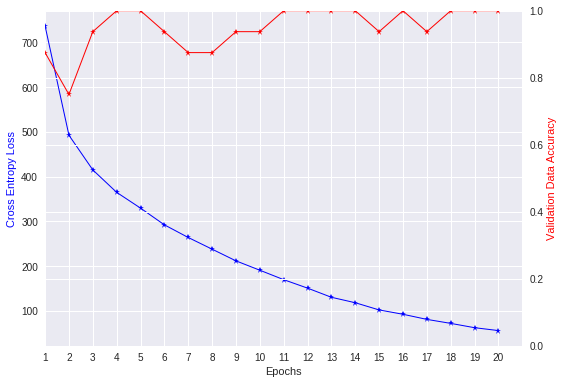

In [140]:
fig3, ax3 = plt.subplots()
ax3b=ax3.twinx()

ax3.plot(range(1, epochs+1), train[0], 'b*-', lw = 1)
ax3b.plot(range(1, epochs+1), train[1], 'r*-', lw = 1 )

ax3.set_xlabel('Epochs')
ax3.set_ylabel('Cross Entropy Loss', color = 'b')
ax3b.set_ylabel('Validation Data Accuracy', color = 'r')

ax3.set_xlim(1, epochs+1)
ax3b.set_ylim((0,1))

ax3.set_xticks(ticks = range(1, epochs+1))

fig3.tight_layout()
plt.show()

## Loading saved model for evaluating on test data

In [141]:
g2 = tf.Graph()

with g2.as_default():
    
    cnn_build(learning_rate=0.0001)
    
    
    saver = tf.train.Saver()


Building 1st convolution layer: 
<tf.Variable 'conv1/_weights:0' shape=(3, 3, 1, 64) dtype=float32_ref>
<tf.Variable 'conv1/_biases:0' shape=(64,) dtype=float32_ref>
Tensor("conv1/Conv2D:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("conv1/preactivation:0", shape=(?, 28, 28, 64), dtype=float32)
Tensor("conv1/activation:0", shape=(?, 28, 28, 64), dtype=float32)

Max pooling the 1st convolution layer:

Building 2nd convolution layer: 
<tf.Variable 'conv2/_weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>
<tf.Variable 'conv2/_biases:0' shape=(128,) dtype=float32_ref>
Tensor("conv2/Conv2D:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("conv2/preactivation:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("conv2/activation:0", shape=(?, 14, 14, 128), dtype=float32)

Max pooling the 2nd convolution layer:

Building the 1st fully connected layer:
<tf.Variable 'fc1/_weights:0' shape=(6272, 2048) dtype=float32_ref>
<tf.Variable 'fc1/_biases:0' shape=(2048,) dtype=float32_ref>
Tensor("f

In [142]:
with tf.Session(graph=g2) as sess:
    
    model_loader(saver=saver, session = sess, epoch = epochs, path='./model')
    
    epochs_2 = 20
    train = train_model(session = sess, training_data = [X_train_scaled, y_train], 
                validation_data=[X_valid_scaled, y_valid], batch_size=64, 
               initialize_var=False, shuffle = True, dropout=0.5, epochs=epochs_2, random_seed=random_seed)
    # Training the model on the data
    
    
    predictions = prediction(session = sess, x_test_data=X_test_scaled)    
        
    test_data_accuracy = np.sum(y_test ==  predictions)
    
    print('Test data accuracy after %d epochs: %.2f' % (epochs+epochs_2, test_data_accuracy/len(y_test)*100))
    
    
    model_saver(saver = saver, session = sess, epoch=epochs+epochs_2)  


Loading saved model at epoch 20 from path ./model
INFO:tensorflow:Restoring parameters from ./model/cnn_model.ckpt-20
Epoch: 01 Average Training Loss:  17.355
Validation data accuracy:   1.000
Epoch: 02 Average Training Loss:  14.698
Validation data accuracy:   1.000
Epoch: 03 Average Training Loss:  14.458
Validation data accuracy:   1.000
Epoch: 04 Average Training Loss:  13.812
Validation data accuracy:   0.938
Epoch: 05 Average Training Loss:  12.702
Validation data accuracy:   1.000
Epoch: 06 Average Training Loss:  11.454
Validation data accuracy:   1.000
Epoch: 07 Average Training Loss:  10.140
Validation data accuracy:   1.000
Epoch: 08 Average Training Loss:   8.982
Validation data accuracy:   1.000
Epoch: 09 Average Training Loss:   9.178
Validation data accuracy:   1.000
Epoch: 10 Average Training Loss:   7.816
Validation data accuracy:   1.000
Epoch: 11 Average Training Loss:   7.774
Validation data accuracy:   1.000
Epoch: 12 Average Training Loss:   7.348
Validation data 

In [0]:
del g2

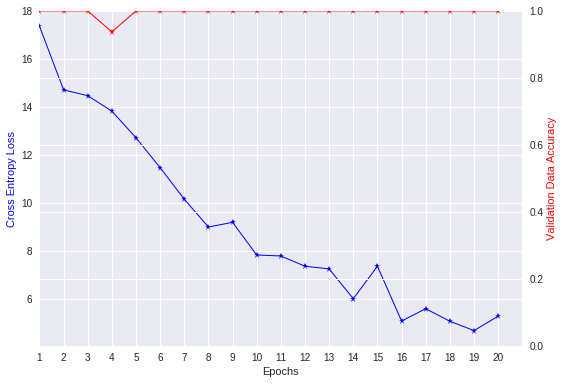

In [144]:
fig4, ax4 = plt.subplots()
ax4b=ax4.twinx()

ax4.plot(range(1, epochs+1), train[0], 'b*-', lw = 1)
ax4b.plot(range(1, epochs+1), train[1], 'r*-', lw = 1 )

ax4.set_xlabel('Epochs')
ax4.set_ylabel('Cross Entropy Loss', color = 'b')
ax4b.set_ylabel('Validation Data Accuracy', color = 'r')

ax4.set_xlim(1, epochs+1)
ax4b.set_ylim((0,1))

ax4.set_xticks(ticks = range(1, epochs+1))

fig4.tight_layout()
plt.show()

## Misclassifications

In [145]:
predictions

array([9, 2, 1, ..., 8, 1, 5], dtype=int32)

In [0]:
misclassified_x = x_test[y_test != predictions]
misclassified_y = y_test[y_test != predictions]
wrong_pred = predictions[y_test != predictions]

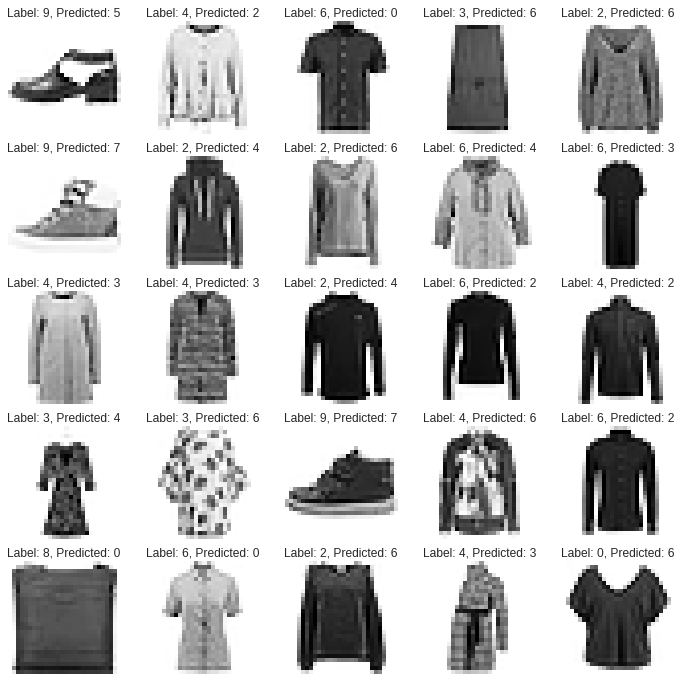

In [147]:
fig6, ax6 = plt.subplots(nrows = 5, ncols=5, figsize = (12,12))

ax6 = ax6.flatten()

for i, ax in enumerate(ax6):
    ax.imshow(misclassified_x[i])
    ax.set_title('Label: %d, Predicted: %d' % (misclassified_y[i], wrong_pred[i]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()